# Batik Classification - ViT Model 

This project is an experiment following my deep learning project assigment to classify batik motifs ([Github link repo](https://github.com/marvelm69/Batik-Classification)) using MobileNetV2 and scratch CNN based model.In my previous project, the trained models showed unstable performance that could be seen in confusion matrix and loss of both train and validation. Furthermore, the uses of visio transformer model is preferable, since it can capture motif's relationship accurately using self-attention mechanism.

## Preparing project

In [5]:
#installing important library 
!pip install pandas matplotlib torch torchvision scikit-learn

     |████████████████████████████████| 13.1 MB 5.6 MB/s eta 0:00:01
     |████████████████████████████████| 8.3 MB 98.0 MB/s eta 0:00:01
     |████████████▌                   | 312.6 MB 107.4 MB/s eta 0:00:05

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



     |████████████████████████████████| 797.2 MB 15 kB/s s eta 0:00:013     |████████████████████████        | 598.9 MB 76.3 MB/s eta 0:00:03     |██████████████████████████▋     | 664.2 MB 20.1 MB/s eta 0:00:07
     |████████████████████████████████| 7.0 MB 39.7 MB/s eta 0:00:01
     |████████████████████████████████| 13.4 MB 27.4 MB/s eta 0:00:01
     |████████████████████████████████| 345 kB 23.6 MB/s eta 0:00:01
     |████████████████████████████████| 19.5 MB 14.9 MB/s eta 0:00:01
     |████████████████████████████████| 1.6 MB 27.4 MB/s eta 0:00:01
     |████████████████████████████████| 4.5 MB 30.5 MB/s eta 0:00:01
     |████████████████████████████████| 103 kB 38.3 MB/s eta 0:00:01
     |████████████████████████████████| 304 kB 37.8 MB/s eta 0:00:01
     |████████████████████████████████| 4.6 MB 38.5 MB/s eta 0:00:01
     |████████████████████████████████| 23.7 MB 21.1 MB/s eta 0:00:01
     |████████████████████████████████| 124.2 MB 39 kB/s s eta 0:00:01
     |██████████████████

In [7]:
#preparing kaggle
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

     |████████████████████████████████| 82 kB 1.8 MB/s eta 0:00:01
     |████████████████████████████████| 78 kB 12.0 MB/s eta 0:00:01
     |████████████████████████████████| 78 kB 11.7 MB/s eta 0:00:01
  Created wheel for kaggle: filename=kaggle-1.6.17-py3-none-any.whl size=105786 sha256=993052f8f12d365d185eca7bdd697974635b627292c005b3f5d4b8f21538f8a1
  Stored in directory: /home/studio-lab-user/.cache/pip/wheels/2b/af/a9/70bffa2773af622d2ebea9c8d407720b86e67bd40c465bf837
Successfully built kaggle


In [14]:
# download dataset
!kaggle datasets download -d dionisiusdh/indonesian-batik-motifs

Dataset URL: https://www.kaggle.com/datasets/dionisiusdh/indonesian-batik-motifs
License(s): CC0-1.0
indonesian-batik-motifs.zip: Skipping, found more recently modified local copy (use --force to force download)


In [13]:
# unzip downloaded dataset
!unzip indonesian-batik-motifs.zip

Archive:  indonesian-batik-motifs.zip
  inflating: batik-bali/1.jpg        
  inflating: batik-bali/10.jpg       
  inflating: batik-bali/11.jpg       
  inflating: batik-bali/12.jpg       
  inflating: batik-bali/13.jpg       
  inflating: batik-bali/14.jpg       
  inflating: batik-bali/15.jpg       
  inflating: batik-bali/16.jpg       
  inflating: batik-bali/17.jpg       
  inflating: batik-bali/18.jpg       
  inflating: batik-bali/19.jpg       
  inflating: batik-bali/2.jpg        
  inflating: batik-bali/20.jpg       
  inflating: batik-bali/21.jpg       
  inflating: batik-bali/22.jpg       
  inflating: batik-bali/23.jpg       
  inflating: batik-bali/24.jpg       
  inflating: batik-bali/25.jpg       
  inflating: batik-bali/26.jpg       
  inflating: batik-bali/27.jpg       
  inflating: batik-bali/28.jpg       
  inflating: batik-bali/29.jpg       
  inflating: batik-bali/3.jpg        
  inflating: batik-bali/30.jpg       
  inflating: batik-bali/31.jpg       
  inflating:

In [1]:
#importing used library
import numpy as np 
import pandas as pd 
import os , time
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import shutil
from PIL import Image, ImageOps, ImageFilter, ExifTags
from sklearn.utils import compute_class_weight
from tempfile import TemporaryDirectory
import torch
import torchvision
import torch.optim as optim
from io import BytesIO
import torch.nn as nn
from torchvision.transforms import v2
from torch.optim import lr_scheduler
from torchvision.io import read_image
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, random_split, Dataset, SubsetRandomSampler
from concurrent.futures import ThreadPoolExecutor
from sklearn.model_selection import KFold

## Exploratory Data Analysis

In [78]:
batik_list = ['batik-betawi','batik-bali','batik-keraton']

<Axes: title={'center': 'Batik Styles Distribution'}, xlabel='count', ylabel='Batik style'>

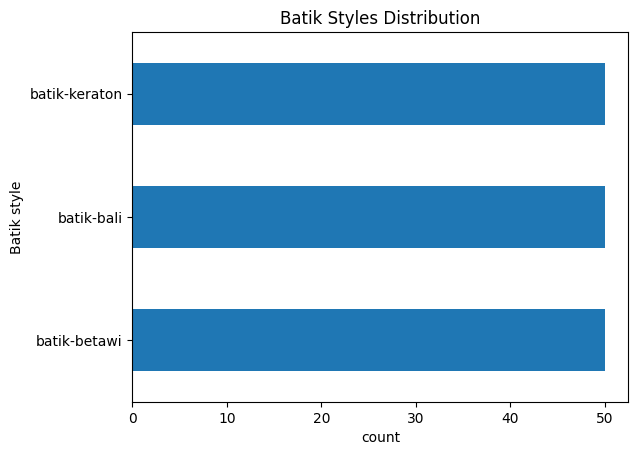

In [79]:
batik_dir_dict = {art : len(os.listdir(art)) for art in batik_list}

batik_series = pd.Series( list(batik_dir_dict.values()) , index = list(batik_dir_dict.keys()))
batik_series.sort_values().plot(kind = 'barh',title = 'Batik Styles Distribution', xlabel = 'count', ylabel = 'Batik style')

## Data Preprocessing

#### Split data into train (80%), validation (10%) and test (10%) 

In [80]:
os.makedirs('train',exist_ok = True)
os.makedirs('validation',exist_ok = True)
os.makedirs('test',exist_ok = True)

In [81]:
def check_indx(x,train_cnt,validation_cnt):
    if x > validation_cnt : 
        return 'test' 
    elif x > train_cnt : 
        return 'validation'
    return 'train'

#resizing image and resampling image using LANZCOS
def resize_image(input_path, output_path):
    try:
        with Image.open(input_path) as img:
            img = img.resize((224, 224), Image.Resampling.LANCZOS)
            img = img.convert('RGB')
            img.save(output_path, 'png')
    except Exception as e:
        print(f"Error processing {input_path}: {str(e)}")
        return False

In [82]:
for cls_name in batik_list:
    class_dir = f'{cls_name}/'
    img_files = os.listdir(class_dir)

    image_files_cnt = len(img_files)
    train_cnt = int(image_files_cnt * 0.80)
    validation_cnt = int(image_files_cnt * 0.90)

    img_files = img_files[:image_files_cnt]
    img_file_paths = [os.path.join(class_dir, img) for img in img_files]

    os.makedirs(f'train/{cls_name}/', exist_ok=True)
    os.makedirs(f'validation/{cls_name}/', exist_ok=True)
    os.makedirs(f'test/{cls_name}/', exist_ok=True)

    for i in range(len(img_file_paths)):
        input_path = img_file_paths[i]
        step_segment = check_indx(i, train_cnt,validation_cnt)
        output_path = os.path.join(f'{step_segment}/', cls_name, img_files[i])
        resize_image(input_path,output_path)

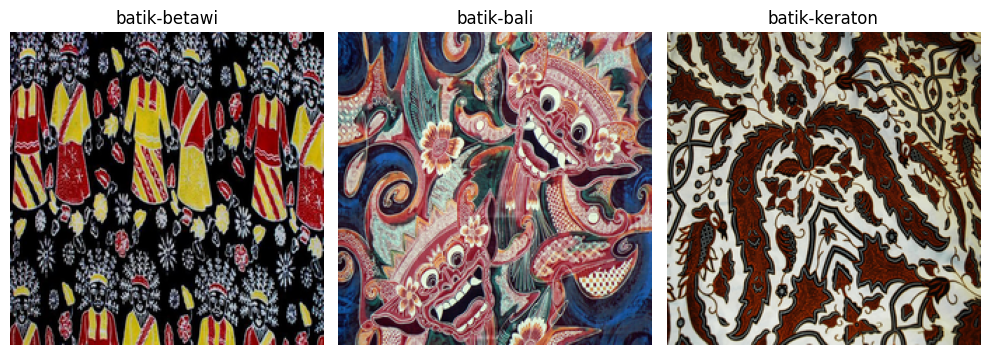

In [84]:
fig, axes = plt.subplots(1,3, figsize = (10,8))

for i in range(3):
    cls_name = batik_list[i]
    class_dir = f'train/{cls_name}/'
    img_files = os.listdir(class_dir)[0]
    img_file_path = os.path.join(class_dir,img_files)
    img = mpimg.imread(img_file_path)
    axes[i].imshow(img)
    axes[i].set_title(cls_name)
    axes[i].axis('off')
        
fig.tight_layout()

### Data Augmentation

This data augmentation pipeline for training applies random transformations to the images, such as slight rotations, horizontal and vertical flips, and color adjustments (brightness, contrast, saturation, and hue), along with random resized cropping to 224x224 pixels. These augmentations help the model generalize by simulating variations in the dataset. After augmentation, the images are converted to tensors, normalized with standard mean and standard deviation values, and scaled to the proper data type. The validation and test sets are only resized, converted, and normalized without augmentations to maintain consistency.

In [85]:
transformation_dict = {
    'train': v2.Compose([
        v2.RandomRotation(10),
        v2.RandomHorizontalFlip(),
        v2.RandomVerticalFlip(),
        v2.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.03),
        v2.RandomResizedCrop(size=224, scale=(0.9, 1.0), ratio=(0.95, 1.05)),
        v2.ToImage(),
        v2.ToDtype(torch.float32, scale=True),
        v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
    'validation': v2.Compose([
        v2.ToImage(),
        v2.ToDtype(torch.float32, scale=True),
        v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
    'test': v2.Compose([
        v2.ToImage(),
        v2.ToDtype(torch.float32, scale=True),
        v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
}


In [86]:
segments = ['train','validation','test']
dataset_dict = {seg : datasets.ImageFolder(f'{seg}/', transform = transformation_dict[seg]) for seg in segments}
loader_dict = {seg : DataLoader(dataset_dict[seg], shuffle = True, batch_size = 32, num_workers = 4,pin_memory=True) for seg in segments}
length_dataset = {seg : len(dataset_dict[seg]) for seg in segments}

In [87]:
length_dataset

{'train': 123, 'validation': 15, 'test': 12}

## Modelling

In [88]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [90]:
model = models.vit_b_16(weights = 'DEFAULT')

for param in model.parameters():
    param.requires_grad = False
    
fc_input = model.heads.head.in_features
model.heads.head = nn.Sequential(
    nn.Linear(fc_input, 512),
    nn.LeakyReLU(0.2),
    nn.Dropout(p=0.5),
    nn.Linear(512, 3),
    nn.Softmax(dim=1)
)

model = model.to(device)
print(model)

VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

In [91]:
optimizer = optim.Adam(model.parameters(), lr = 1e-4, weight_decay=1e-5)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode = 'max', patience = 3)
loss = nn.CrossEntropyLoss() 

In [92]:
scaler = torch.cuda.amp.GradScaler()
torch.backends.cudnn.benchmark = True

/tmp/ipykernel_27530/1688677953.py:1: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


### Training using K-Fold method

In [93]:
def train_model_kfold(model = model, optimizer = optimizer, criterion = loss, scheduler = lr_scheduler, scaler = scaler, dataset_dict = dataset_dict, loader_dict = loader_dict, length_dataset = length_dataset, n_epochs=30, k=5):
    since = time.time()
    kfold = KFold(n_splits=k, shuffle=True)
    steps = ['train', 'validation']
    loss_list = {'train': [], 'validation': []}
    metric_list = {'train': [], 'validation': []}
    best_val_metric = 0.0

    combined_dataset = torch.utils.data.ConcatDataset([dataset_dict['train'], dataset_dict['validation']])
    combined_length = len(combined_dataset)

    for fold, (train_idx, val_idx) in enumerate(kfold.split(range(combined_length))):
        print(f'Fold {fold + 1}/{k}')
        print('-' * 10)

        train_sampler = SubsetRandomSampler(train_idx)
        val_sampler = SubsetRandomSampler(val_idx)
        train_loader = DataLoader(combined_dataset, sampler=train_sampler, batch_size=32, num_workers=4, pin_memory=True)
        val_loader = DataLoader(combined_dataset, sampler=val_sampler, batch_size=32, num_workers=4, pin_memory=True)
        loader_dict_fold = {'train': train_loader, 'validation': val_loader}
        length_dataset_fold = {'train': len(train_sampler), 'validation': len(val_sampler)}

        for epoch in range(n_epochs):
            print(f'Epoch {epoch}/{n_epochs - 1}')
            print('-' * 10)

            for step in steps:
                if step == 'train':
                    model.train()
                else:
                    model.eval()

                running_loss = 0.0 
                running_metrics = 0 

                for inputs, labels in loader_dict_fold[step]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    optimizer.zero_grad(set_to_none=True)

                    with torch.set_grad_enabled(step == 'train'): 
                        with torch.cuda.amp.autocast():
                            output = model(inputs)
                            loss = criterion(output, labels)
                        
                        _, preds = torch.max(output, 1)

                        if step == 'train':
                            scaler.scale(loss).backward()
                            scaler.step(optimizer)
                            scaler.update()
                            
                    running_loss += loss.item() * inputs.size(0)
                    running_metrics += torch.sum(preds == labels.data)
                    
                epoch_loss = running_loss / length_dataset_fold[step]
                epoch_metrics = running_metrics.double() / length_dataset_fold[step]

                loss_list[step].append(epoch_loss)
                metric_list[step].append(epoch_metrics)

                print(f'{step} Loss: {epoch_loss:.4f} Acc: {epoch_metrics:.4f}')
                
                if step == 'validation':
                    best_val_metric = max(best_val_metric, epoch_metrics)
        
            scheduler.step(metric_list['validation'][-1])    
            print()
        
        time_elapsed = time.time() - since
        print(f'Fold {fold + 1} complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print()

    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc overall: {best_val_metric:.4f}')
    
    return model, metric_list, loss_list

model, metric_history, loss_history = train_model_kfold()

Fold 1/5
----------
Epoch 0/29
----------


/tmp/ipykernel_27530/1925388690.py:43: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


train Loss: 1.1063 Acc: 0.3455
validation Loss: 1.1103 Acc: 0.3571

Epoch 1/29
----------
train Loss: 1.0789 Acc: 0.4455
validation Loss: 1.1039 Acc: 0.3571

Epoch 2/29
----------
train Loss: 1.0587 Acc: 0.5455
validation Loss: 1.1020 Acc: 0.2857

Epoch 3/29
----------
train Loss: 1.0482 Acc: 0.5545
validation Loss: 1.1009 Acc: 0.2857

Epoch 4/29
----------
train Loss: 1.0234 Acc: 0.6455
validation Loss: 1.0899 Acc: 0.3929

Epoch 5/29
----------
train Loss: 1.0102 Acc: 0.7182
validation Loss: 1.0872 Acc: 0.4286

Epoch 6/29
----------
train Loss: 0.9773 Acc: 0.7545
validation Loss: 1.0742 Acc: 0.4643

Epoch 7/29
----------
train Loss: 0.9656 Acc: 0.7364
validation Loss: 1.0730 Acc: 0.3929

Epoch 8/29
----------
train Loss: 0.9578 Acc: 0.7818
validation Loss: 1.0511 Acc: 0.4643

Epoch 9/29
----------
train Loss: 0.9437 Acc: 0.7818
validation Loss: 1.0405 Acc: 0.5714

Epoch 10/29
----------
train Loss: 0.9181 Acc: 0.8364
validation Loss: 1.0438 Acc: 0.5000

Epoch 11/29
----------
train Lo

## Evaluating Model

In [94]:
def evaluate_model(model, test_loader, test_length, device):
    model.eval()
    test_running_correct = 0
    test_running_loss = 0
    all_predictions = []
    all_labels = []
    criterion = nn.CrossEntropyLoss()

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            _, preds = torch.max(outputs, 1)
            test_running_correct += torch.sum(preds == labels.data)
            test_running_loss += loss.item() * inputs.size(0)

            all_predictions.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    test_accuracy = test_running_correct.double() / test_length
    test_loss = test_running_loss / test_length

    return test_accuracy, test_loss, all_predictions, all_labels

val_accuracy, val_loss, all_predictions, all_labels = evaluate_model(model, loader_dict['test'], length_dataset['test'], device )

### Metric Tables

In [103]:
from sklearn.metrics import classification_report

labels_dict = dataset_dict['test'].class_to_idx

print(classification_report(all_predictions, all_labels,  target_names=labels_dict ))

               precision    recall  f1-score   support

   batik-bali       0.50      0.67      0.57         3
 batik-betawi       1.00      0.80      0.89         5
batik-keraton       0.75      0.75      0.75         4

     accuracy                           0.75        12
    macro avg       0.75      0.74      0.74        12
 weighted avg       0.79      0.75      0.76        12



In [105]:
labels_dict

{'batik-bali': 0, 'batik-betawi': 1, 'batik-keraton': 2}

### Confusion Matrix

In [112]:
def confusion_matrix(all_predictions, all_labels, labels_dict):
    labels_dict = {labels_dict[x]:x for x in labels_dict}
    def convert_to_actual_label(x):
        return labels_dict[x]
    all_predictions = [convert_to_actual_label(x) for x in all_predictions]
    all_labels = [convert_to_actual_label(x) for x in all_labels]
    return pd.crosstab(all_predictions, all_labels)

confusion_matrix(all_predictions, all_labels, labels_dict)

col_0,batik-bali,batik-betawi,batik-keraton
row_0,,,
batik-bali,2,0,1
batik-betawi,1,4,0
batik-keraton,1,0,3


### Training Learning curve

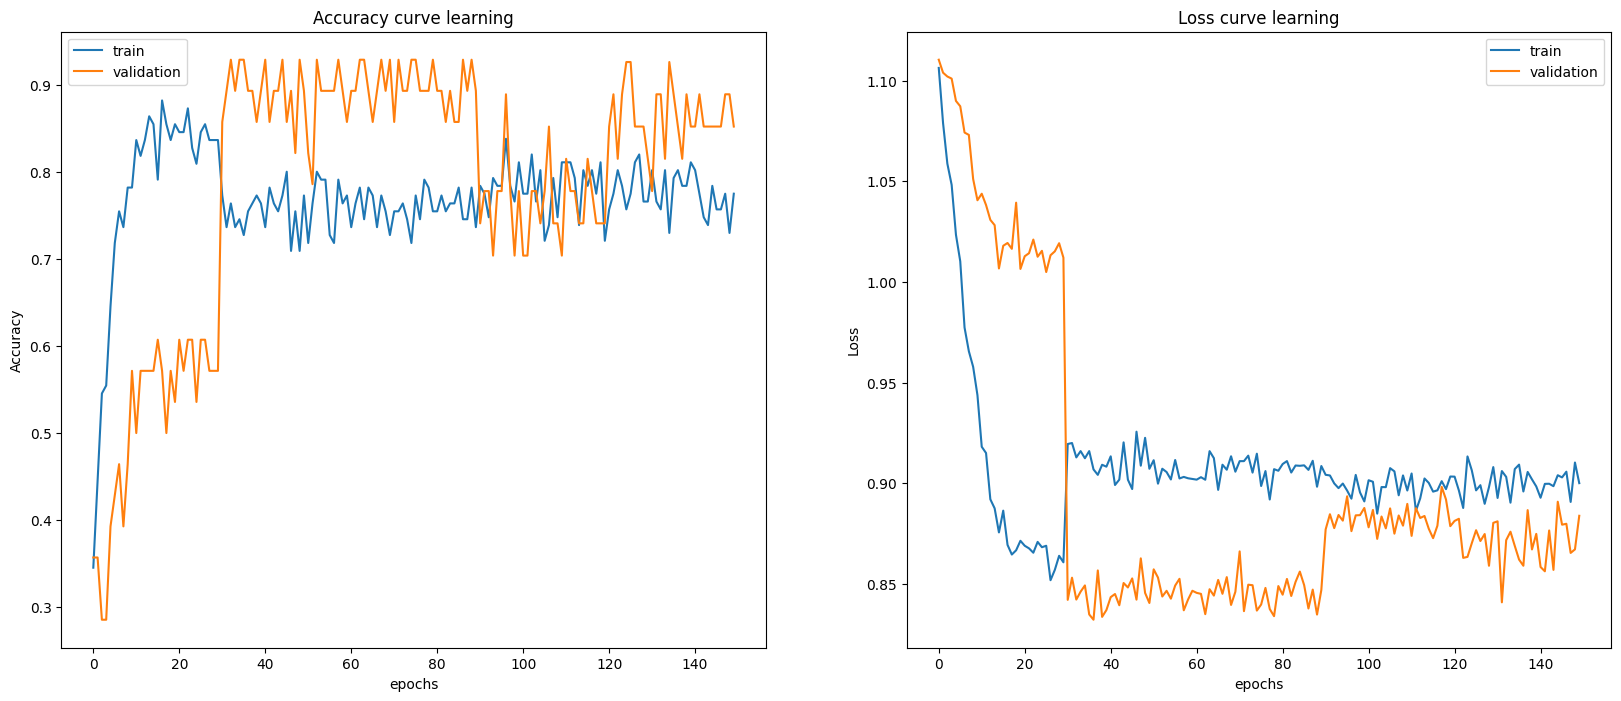

In [97]:
hist_histories = [metric_history, loss_history]
hist_title = ['Accuracy curve learning', 'Loss curve learning']
hist_yaxis = ['Accuracy','Loss']
fig,axes = plt.subplots(1,2, figsize = (20,8))

def change_to_cpu_data(li_x):
    return [x.cpu().item() if isinstance(x, torch.Tensor) else x for x in li_x]

for i in range(2):
    train_hist = change_to_cpu_data(hist_histories[i]['train']) 
    valid_hist = change_to_cpu_data(hist_histories[i]['validation'])
    epoch_range = range(len(train_hist))
    axes[i].plot(epoch_range, train_hist, label = 'train')
    axes[i].plot(epoch_range, valid_hist, label = 'validation')
    axes[i].set_title(hist_title[i])
    axes[i].set_xlabel('epochs')
    axes[i].set_ylabel(hist_yaxis[i])
    axes[i].legend()

In [113]:
torch.save(model.state_dict(), 'model_batik.pt')